[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ogooga\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ogooga\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


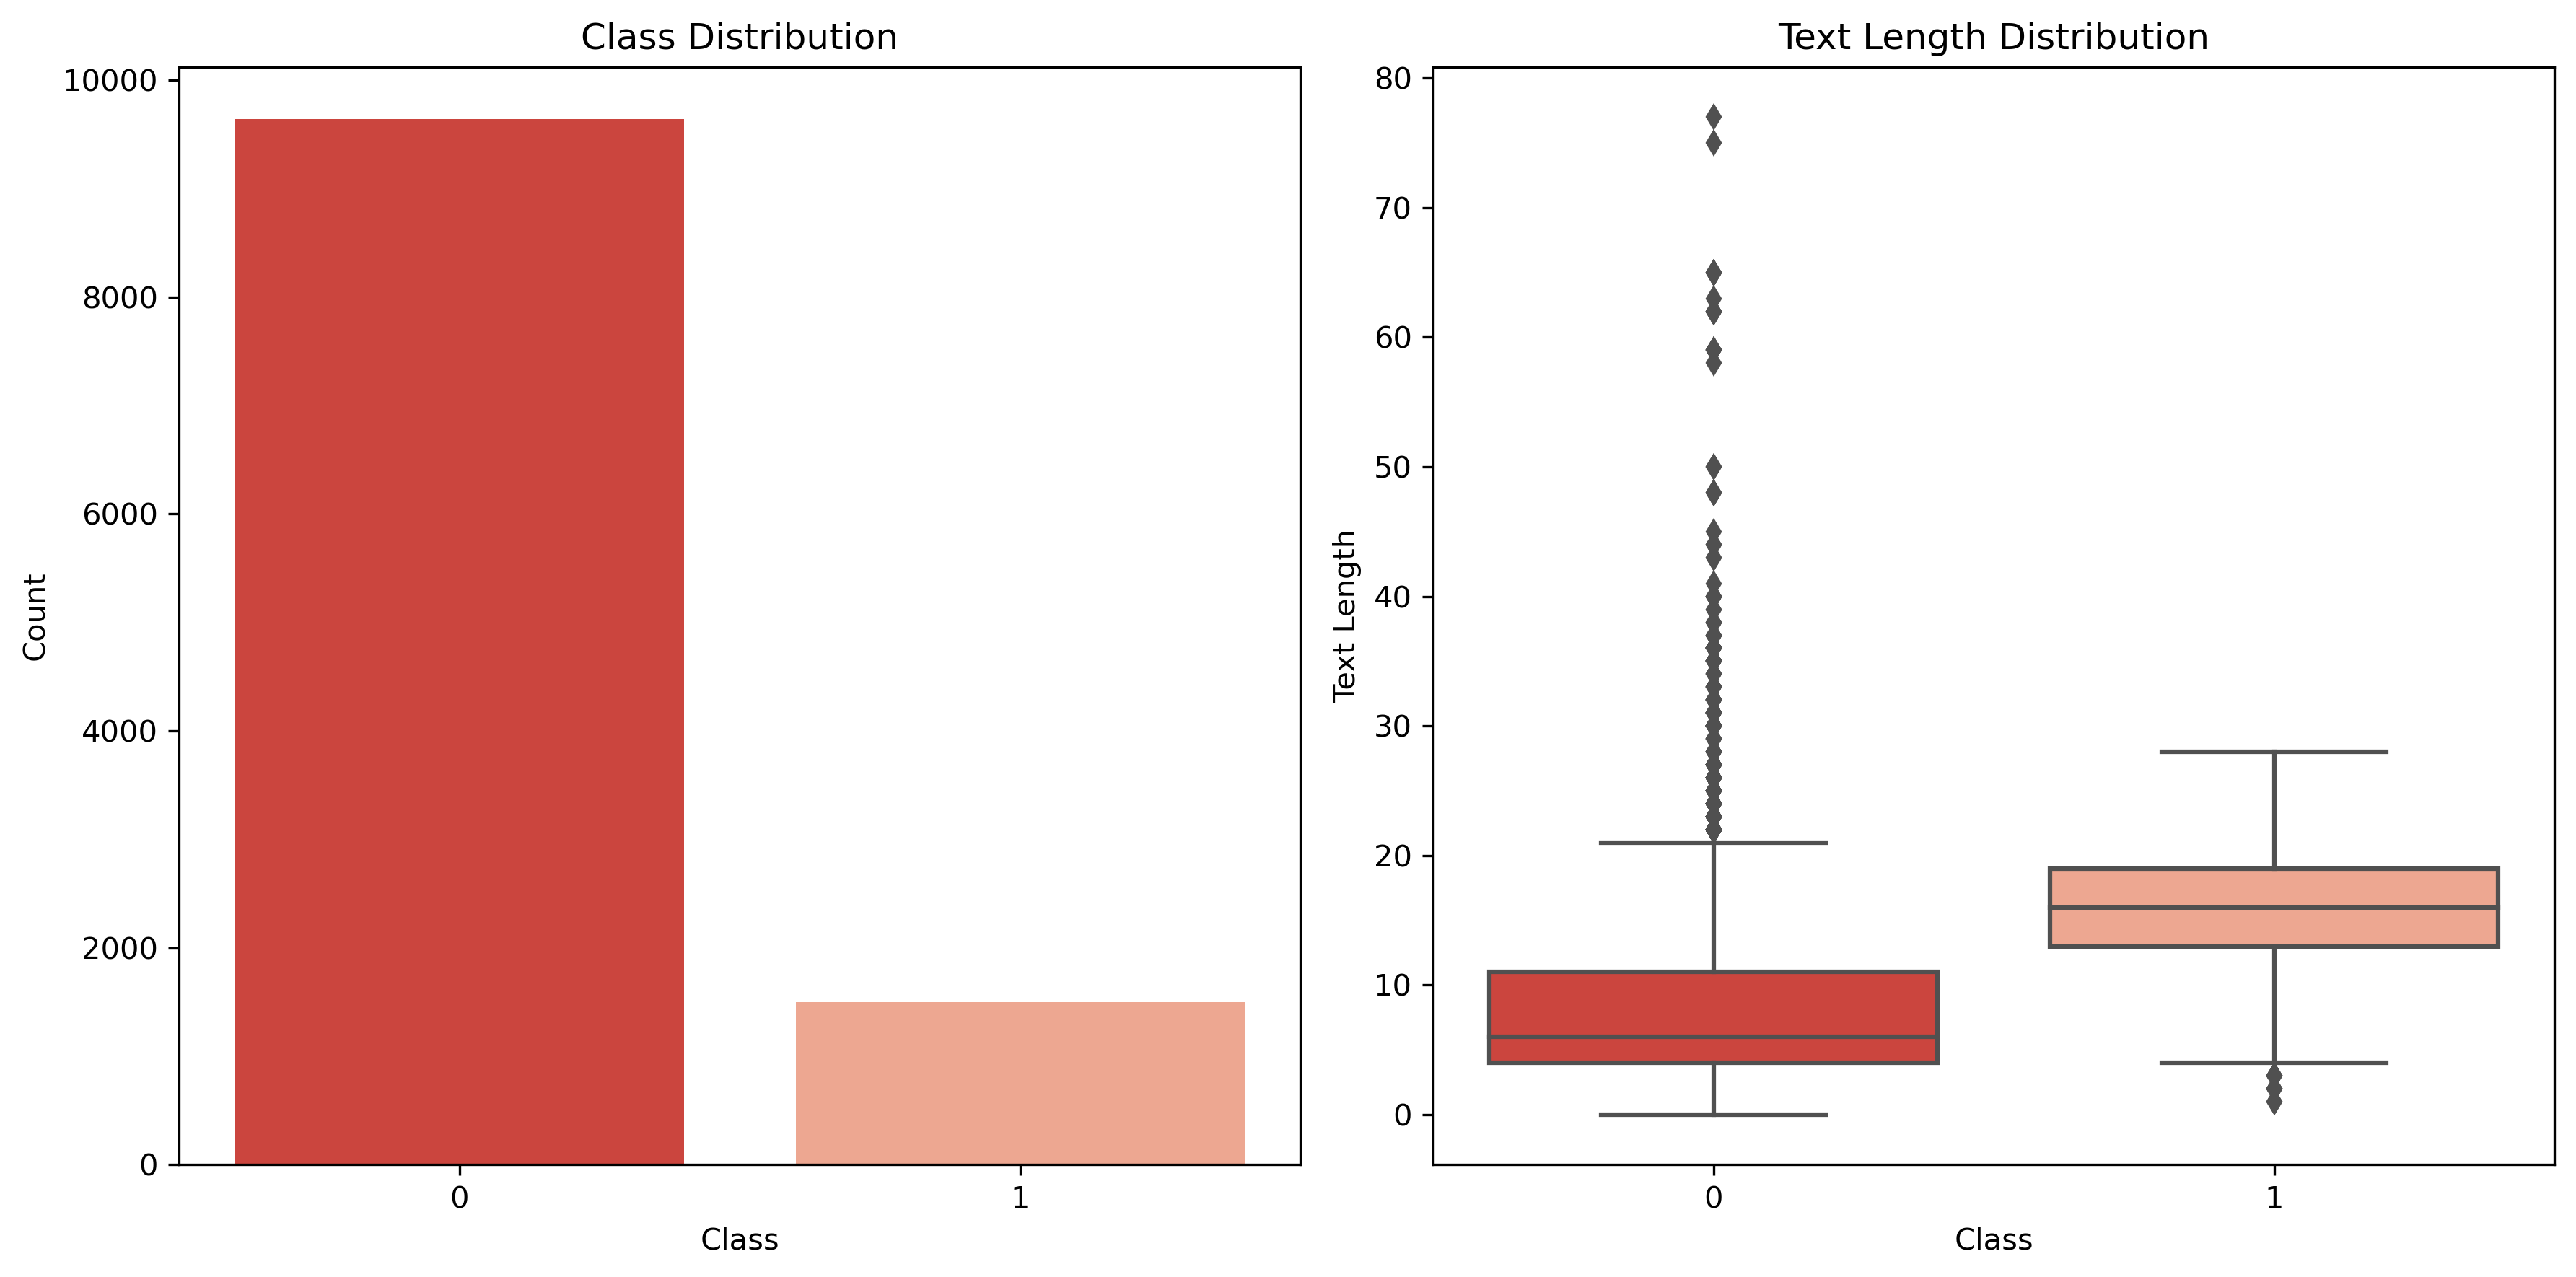

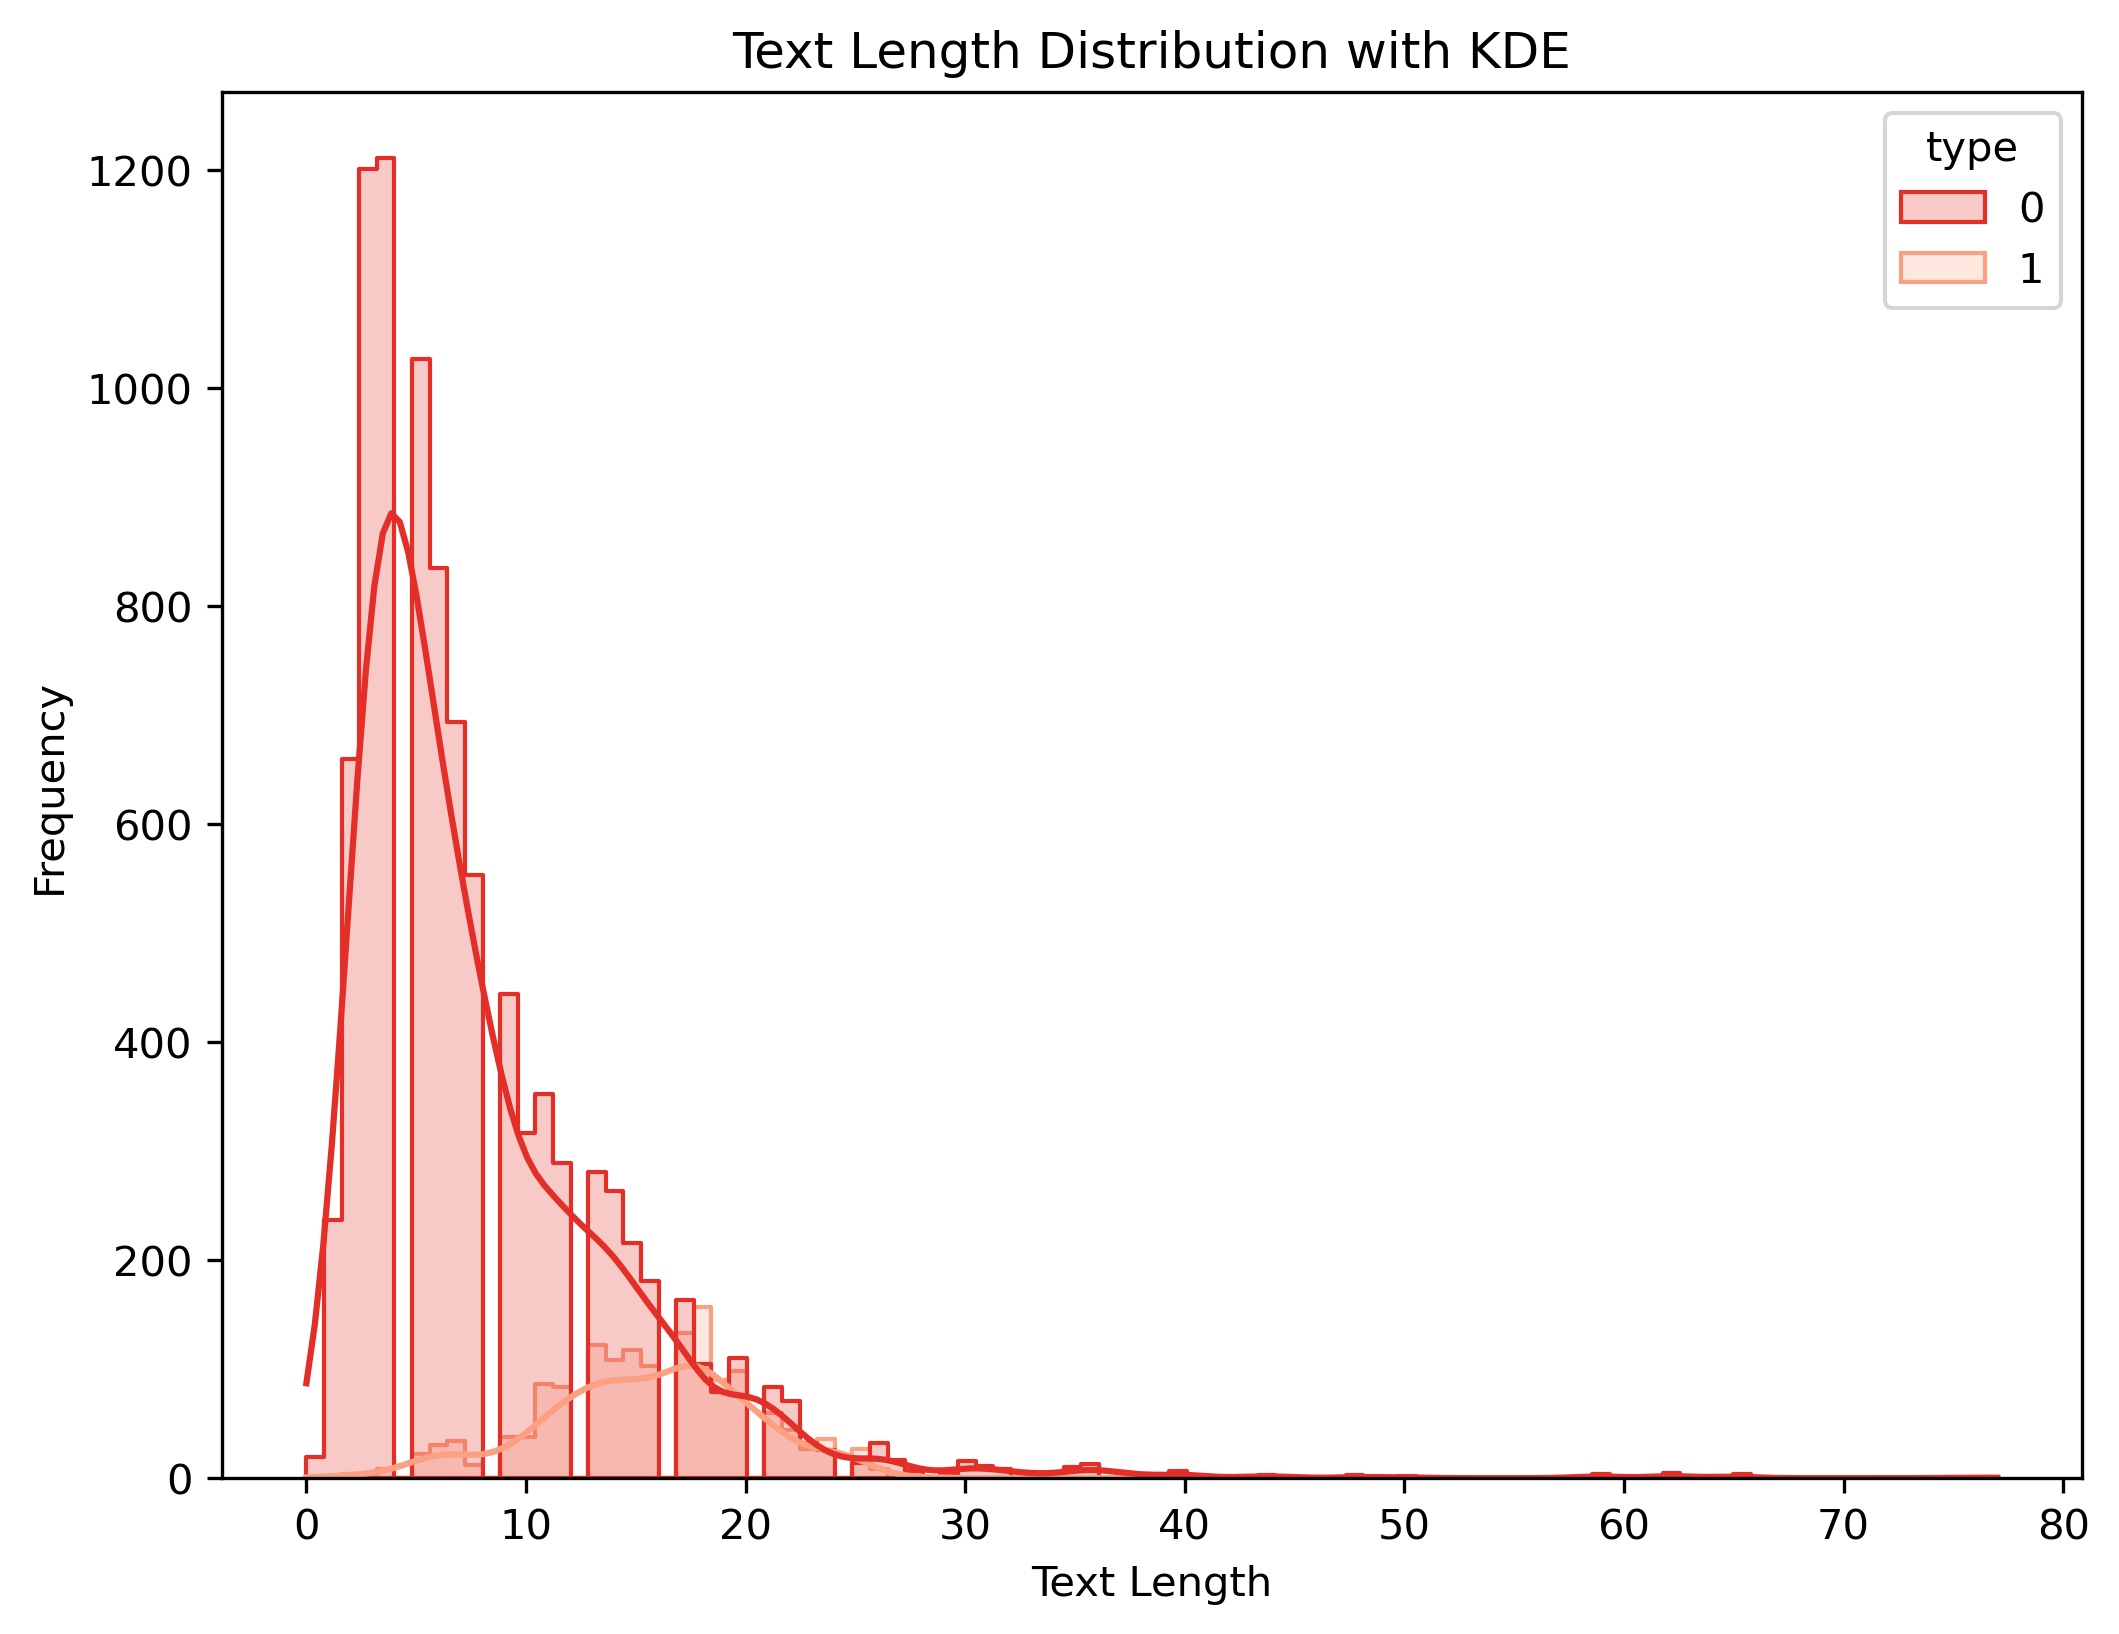

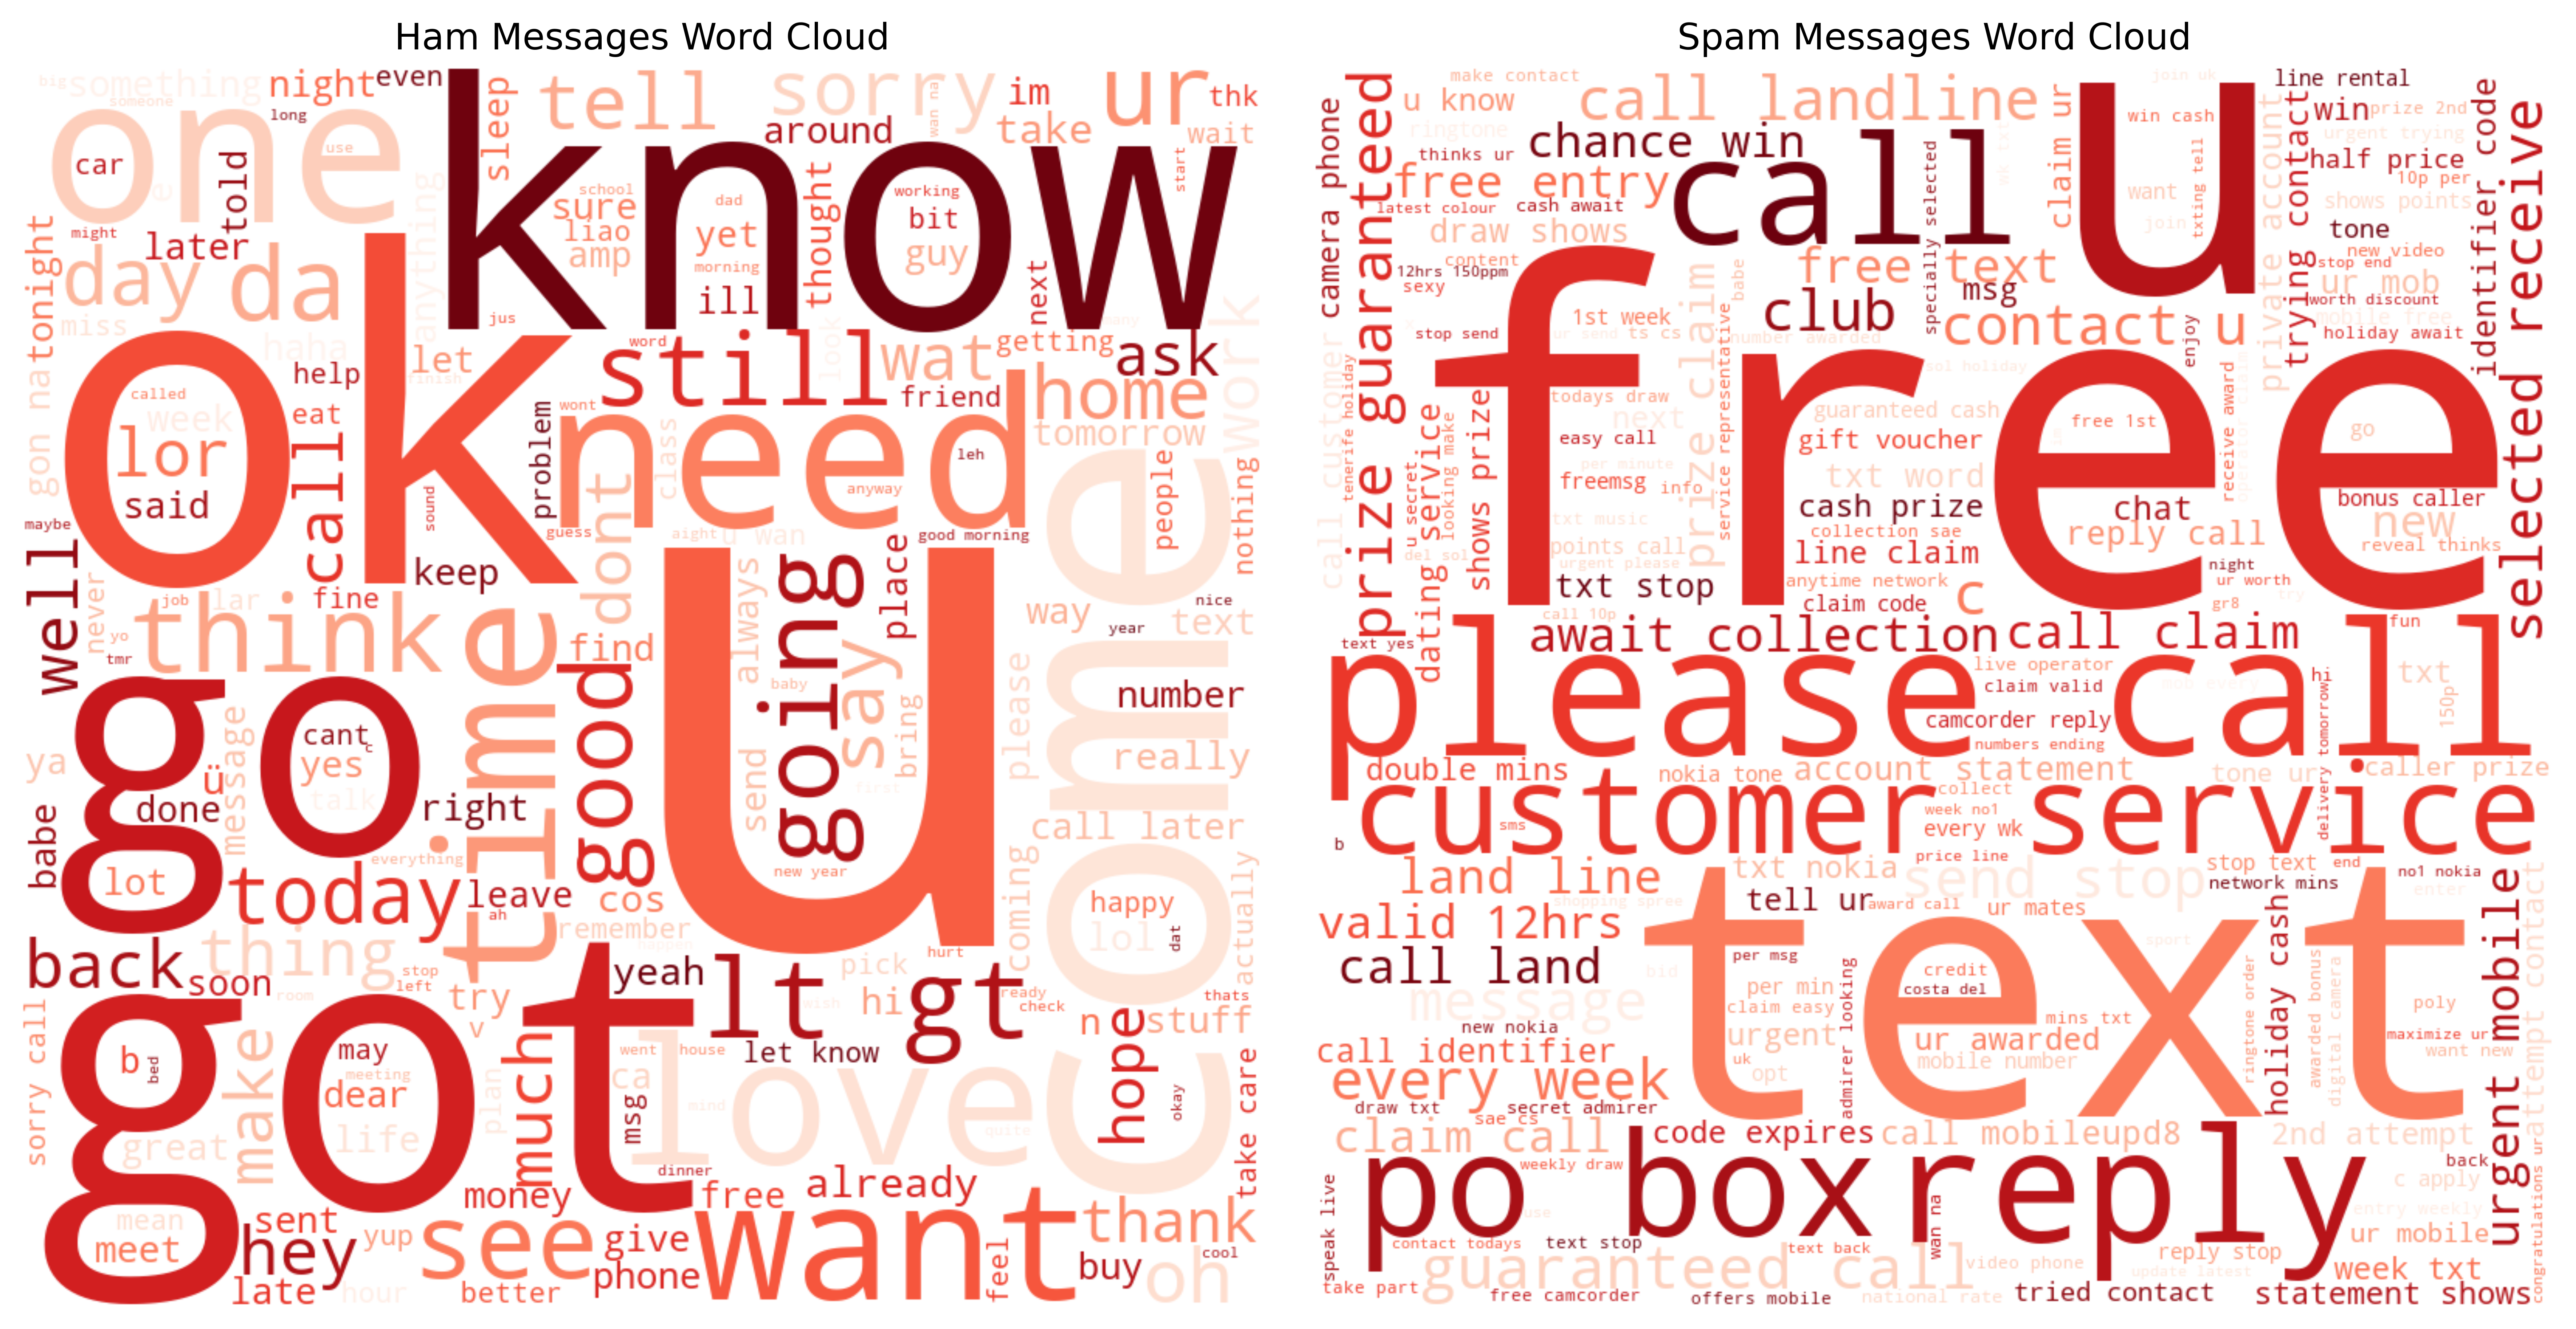

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Naive Bayes Accuracy: 0.9780
Random Forest Accuracy: 0.9955
Linear SVC Accuracy: 0.9897


E:\Programe\anaconda\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Logistic Regression Accuracy: 0.9767
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1924
           1       1.00      0.97      0.98       303

    accuracy                           1.00      2227
   macro avg       1.00      0.98      0.99      2227
weighted avg       1.00      1.00      1.00      2227

Random Forest Accuracy: 0.9955
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1924
           1       0.99      0.94      0.96       303

    accuracy                           0.99      2227
   macro avg       0.99      0.97      0.98      2227
weighted avg       0.99      0.99      0.99      2227

Linear SVC Accuracy: 0.9897
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1924
           1       0.97      0.85      0.91       303

    accuracy                           0.98      2227
   macro avg       0.98      0.9

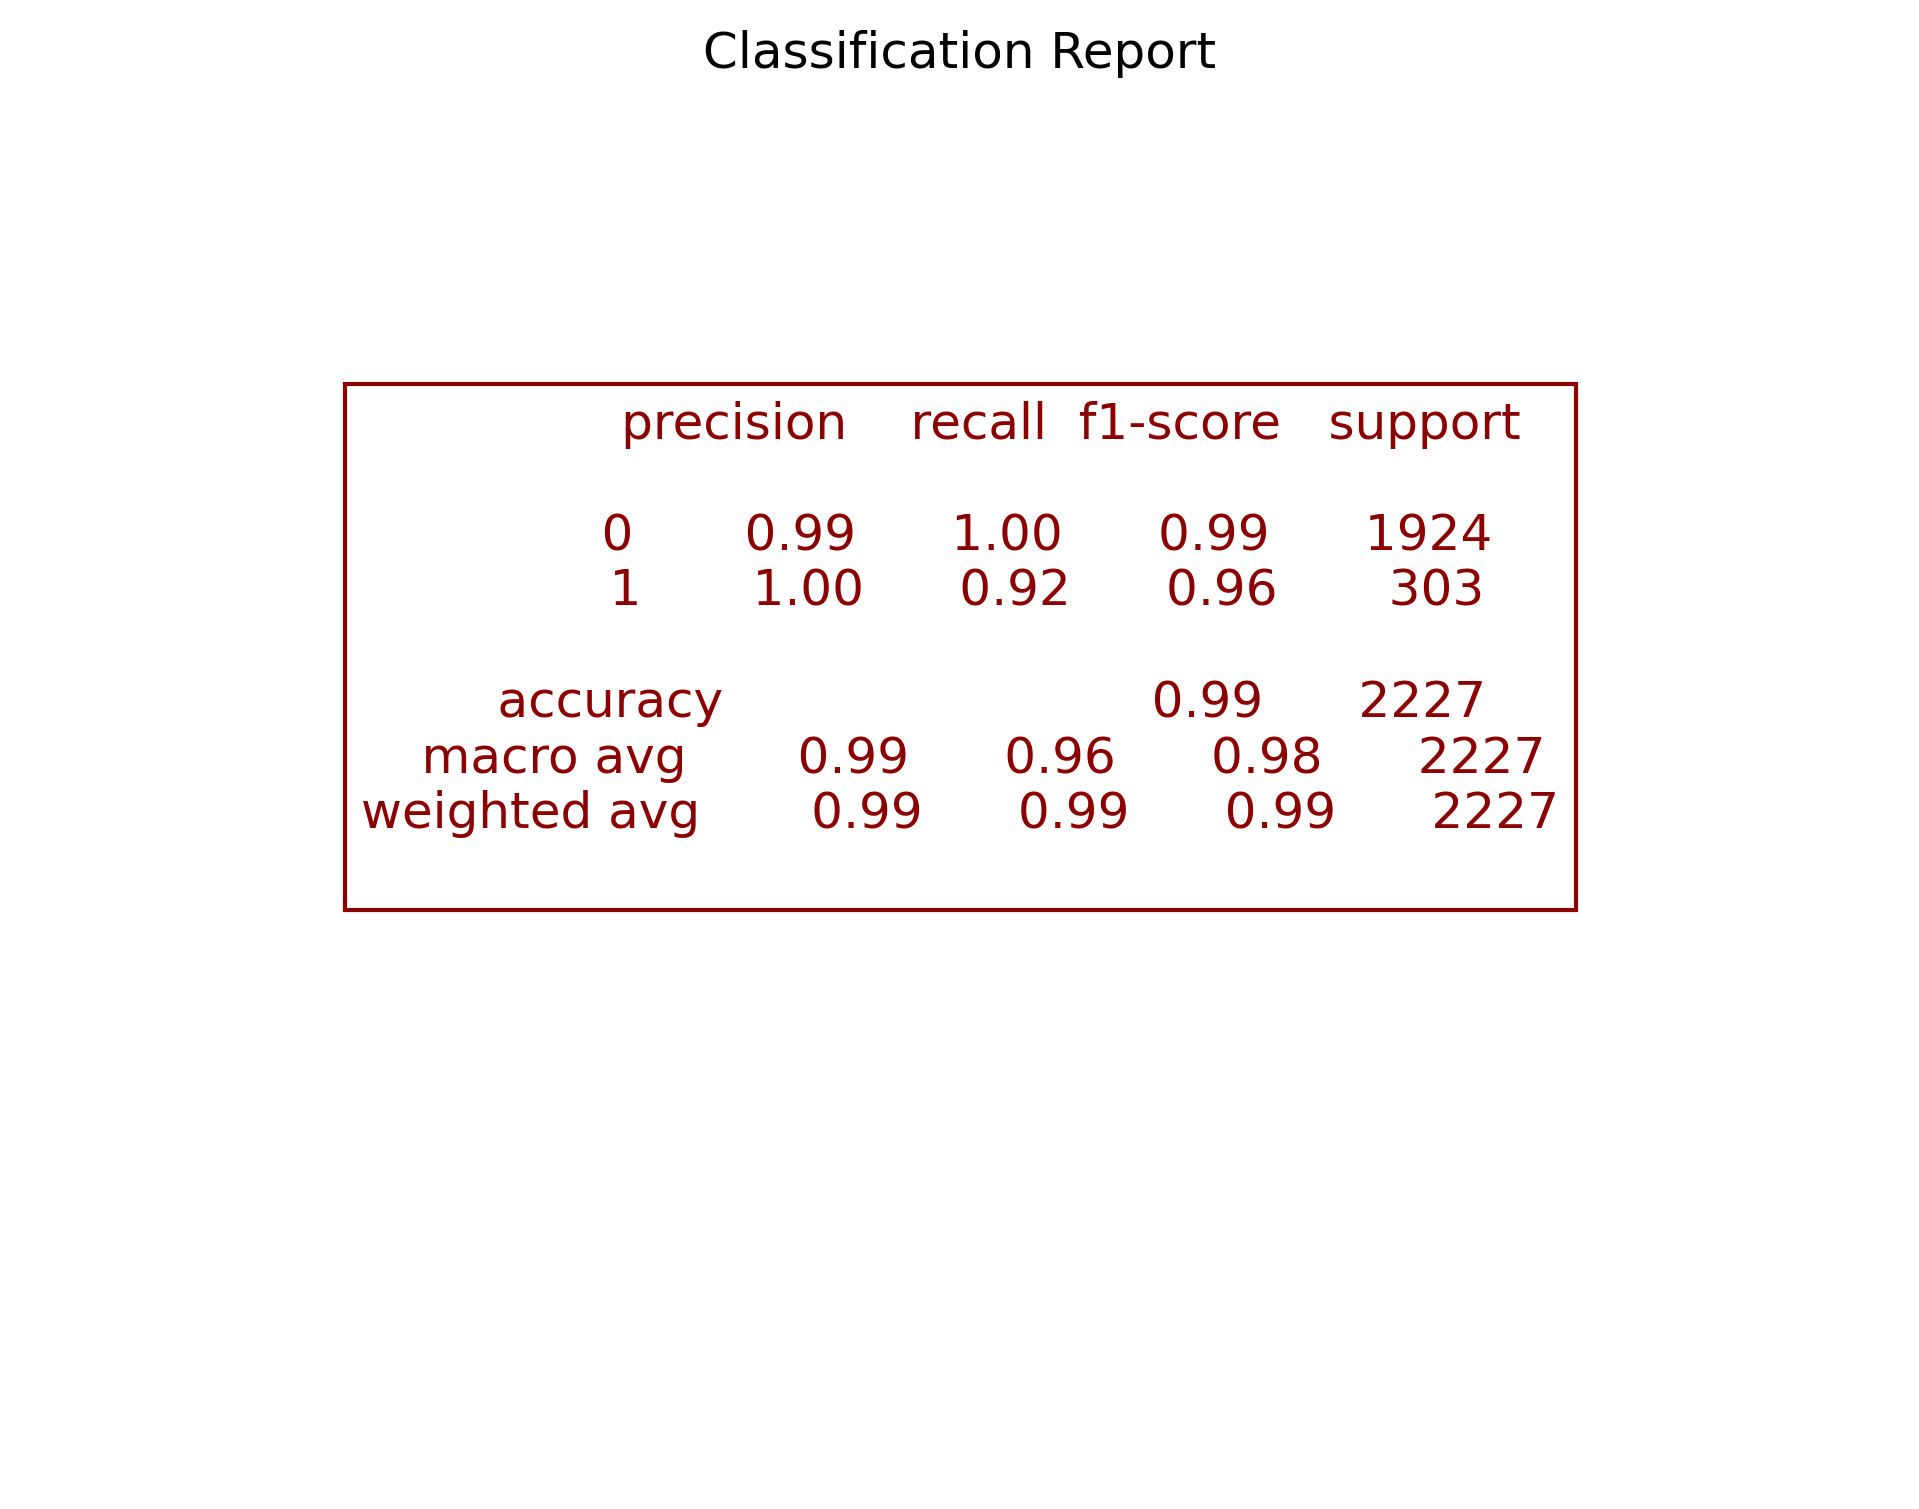

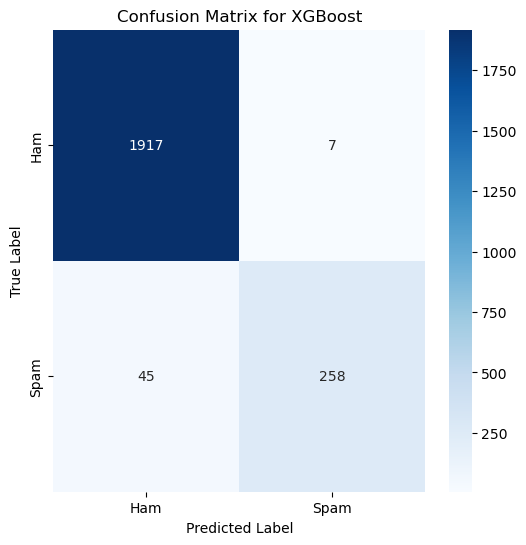

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# NLTK data
nltk.download('punkt')
nltk.download('stopwords')

def load_and_preprocess_dataset(file_path, text_column, label_column):
    df = pd.read_csv(file_path)
    df['type'] = df[label_column].map({'ham': 0, 'spam': 1})
    df['text'] = df[text_column].apply(preprocess_text)
    return df

def preprocess_text(text):
    words = word_tokenize(text)
    words = [word.lower() for word in words if word.isalnum()]
    words = [word for word in words if word not in stopwords.words("english")]
    return " ".join(words)

datasets = [
    {'path': 'spamraw.csv', 'text_column': 'text', 'label_column': 'type'},
    {'path': 'spamsms2.csv', 'text_column': 'sms', 'label_column': 'Class'},
]

all_datasets = pd.concat([load_and_preprocess_dataset(d['path'], d['text_column'], d['label_column']) for d in datasets], ignore_index=True)

# vizualization color
red_palette = sns.color_palette("Reds_r", 2)

# class distribution for all datasets
plt.figure(figsize=(12, 6), dpi=300)
plt.subplot(1, 2, 1)
sns.set_palette(red_palette)
sns.countplot(x='type', data=all_datasets)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

# text length distribution
plt.subplot(1, 2, 2)
all_datasets['text_length'] = all_datasets['text'].apply(lambda x: len(x.split()))
sns.boxplot(x='type', y='text_length', data=all_datasets)
plt.title('Text Length Distribution')
plt.xlabel('Class')
plt.ylabel('Text Length')
plt.tight_layout()
plt.show()

# KDE histogram  
plt.figure(figsize=(8, 6), dpi=300)
sns.set_palette(red_palette)
sns.histplot(data=all_datasets, x='text_length', hue='type', kde=True, element='step')
plt.title('Text Length Distribution with KDE')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# word clouds for all datasets
red_palette_c = sns.color_palette("Reds_r", as_cmap=True)
ham_text = " ".join(all_datasets[all_datasets['type'] == 0]['text'])
spam_text = " ".join(all_datasets[all_datasets['type'] == 1]['text'])

ham_wordcloud = WordCloud(width=800, height=800, background_color='white', colormap=red_palette_c).generate(ham_text)
spam_wordcloud = WordCloud(width=800, height=800, background_color='white', colormap=red_palette_c).generate(spam_text)

ham_image = ham_wordcloud.to_array()
spam_image = spam_wordcloud.to_array()

plt.figure(figsize=(12, 6), dpi=600)
plt.subplot(1, 2, 1)
plt.imshow(ham_image, interpolation='bilinear')
plt.title('Ham Messages Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(spam_image, interpolation='bilinear')
plt.title('Spam Messages Word Cloud')
plt.axis('off')
plt.tight_layout()
plt.show()

# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
X = tfidf_vectorizer.fit_transform(all_datasets['text']).toarray()
y = all_datasets['type']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# xgb params
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

# initialization for xgb
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# gridsearch init
grid_search = GridSearchCV(
    estimator=xgb_classifier, 
    param_grid=param_grid, 
    scoring='accuracy', 
    n_jobs=-1, 
    cv=3, 
    verbose=2
)

# executing gridsearch, finding the best model and applying it
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, y_pred)
xgb_report = classification_report(y_test, y_pred)


# defining other models 
models = {
    "Naive Bayes": MultinomialNB(alpha=.1),
    "Random Forest": RandomForestClassifier(),
    "Linear SVC": LinearSVC(),
    "Logistic Regression": LogisticRegression()
}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")
    
# evaluation for other models
selected_model = models["Naive Bayes"]
y_pred = selected_model.predict(X_test)
report = classification_report(y_test, y_pred)
acc = f"Accuracy is : {accuracy_score(y_test, y_pred):.4f}"

selected_model = models["Random Forest"]
y_pred = selected_model.predict(X_test)
report = classification_report(y_test, y_pred)
acc = f"Random Forest Accuracy: {accuracy_score(y_test, y_pred):.4f}"
print(report)
print(acc)

selected_model = models["Linear SVC"]
y_pred = selected_model.predict(X_test)
report = classification_report(y_test, y_pred)
acc = f"Linear SVC Accuracy: {accuracy_score(y_test, y_pred):.4f}"
print(report)
print(acc)

selected_model = models["Logistic Regression"]
y_pred = selected_model.predict(X_test)
report = classification_report(y_test, y_pred)
acc = f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred):.4f}"
print(report)
print(acc)
print(f"Best XGBoost Model Accuracy: {xgb_accuracy:.4f}")
print(xgb_report)

# classif report
plt.figure(figsize=(8, 6), dpi=300)
plt.text(0.5, 0.6, xgb_report, fontsize=12, color='darkred', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='darkred'))
plt.title('Classification Report')
plt.axis('off')
plt.show()

# confusion for xgboost
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix for XGBoost')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()